<a href="https://colab.research.google.com/github/JanSamanek/Project_Shaman/blob/centroid-method/Siamese%20Network/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Prepare Data For Siamese Network

Load Data and Labels

In [ ]:
train_data_dir = r'/content/drive/MyDrive/bounding_box_train'
val_data_dir = r'/content/drive/MyDrive/bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '/')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

[INFO] loading data...


Visualize Training Data

IMAGE SHAPE:  (128, 64, 3)


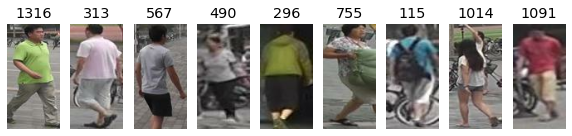

In [ ]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [ ]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"unique label {unique_label} contains {len(idxs)} images")

Make Pairs

In [ ]:
def make_pairs(dataset):
    pairs_list = []
    labels_list = []

    print("[INFO] preparing positive and negative pairs...")

    images = [image for image, label in dataset]
    labels = [label for image, label in dataset]

    unique_labels = np.unique(np.array(labels))

    idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]
    for idx_1 in range(len(labels)):
        label = labels[idx_1]
        img_1 = images[idx_1]
        # randomly pick an image that belongs to the *same* class
        for i in range(2):
            idx_2 = np.random.choice(np.where(np.array(labels) == label)[0])
            img_2 = images[idx_2]
            pairs_list.append((img_1, img_2))
            labels_list.append([1])

        # randomly pick an image that does *not* belong to the same class
        for i in range(2):
            idx_2 = np.random.choice(np.where(np.array(labels) != label)[0])
            img_2 = images[idx_2]
            pairs_list.append((img_1, img_2))
            labels_list.append([0])

    return np.array(pairs_list), np.array(labels_list)

train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

[INFO] preparing positive and negative pairs...
[INFO] preparing positive and negative pairs...


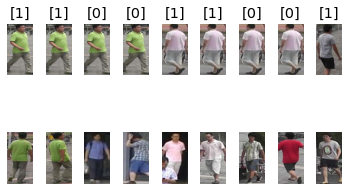

In [ ]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential

Choose a Pretrained Model as Feature Extractor

In [ ]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (128, 64, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(128, 128,3), include_top=False, weights='imagenet')
feature_extractor.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in feature_extractor.layers[:fine_tune_at]:
  layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_extractor.summary()

Create similarity evaluation function

In [ ]:
import tensorflow.keras.backend as K

def euclidean_distance(vectors):
	(features_1, features_2) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(features_1 - features_2), axis=1, keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

Configure Siamese Network

In [ ]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
pooling = GlobalAveragePooling2D()(distance)
dropout = Dropout(0.2)(pooling)
outputs = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=[img_1, img_2], outputs=outputs)      

[INFO] building model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 mobilenetv2_1.00_128 (Function  (None, 4, 4, 1280)  2257984     ['input_5[0][0]',                
 al)                                                              'input_6[0][0]']          

## Training Siamese Network

In [ ]:
BATCH_SIZE = 32
EPOCHS = 40

# compile the model
print("[INFO] compiling model...")
base_learning_rate = 0.0001
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS)

Visualize Training Data

In [ ]:
# visualized data from training can be also found in tensorboard
import matplotlib.pyplot as plt

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="upper right")
	plt.savefig(plotPath)
 
path = "content/logs/training_plot.png"
print("[INFO] plotting training history...")
plot_training(history, path)

Save Siamese Network Model

In [ ]:
model.save("content/model/siamese_network.h5")

## Evaluation

Load Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('content/model/siamese_network.h5')

In [ ]:
predictions = model.predict([val_pair_x[:40,0], val_pair_x[:40,1]])

In [ ]:
for i in range(40):
  # initialize the figure
  fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
  plt.suptitle("Similarity: {:.2f}".format(predictions[i][0]))

  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(val_pair_x[i, 0])
  plt.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(val_pair_x[i, 1])
  plt.axis("off")

  plt.show()